<a href="https://colab.research.google.com/github/2813/dls-homework/blob/main/%5Bhw%5DGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:

DATA_DIR = '/kaggle/input/faces-dataset-small'

In [ ]:
def get_dataloader(image_size, batch_size):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object
    """
  # TODO: resize images, convert them to tensors and build dataloader
    dataset = ImageFolder(DATA_DIR, transform=tt.Compose([tt.ToTensor(), tt.Resize(image_size, antialias=True)]))
    dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2)
    return dataloader

In [ ]:
image_size = 128
batch_size = 32
#TODO: build dataloader and transfer it to device
dataloader = get_dataloader(image_size, batch_size)


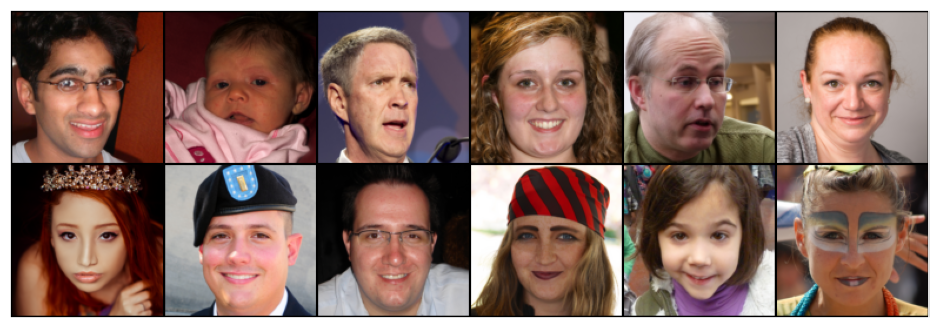

In [ ]:
imgs, _ = next(iter(dataloader))
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(
    make_grid(imgs[:12], nrow=6).permute(1, 2, 0)
)
#show_images(test_imgs)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid()

).to(DEVICE)

In [ ]:
latent_size = 100

generator = nn.Sequential(

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),

    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()

).to(DEVICE)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
lr = 0.0001

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
optimizer = {
    'discriminator': torch.optim.Adam(
        model['discriminator'].parameters(), lr=lr, betas=(0.5, 0.999)
    ),
    'generator': torch.optim.Adam(
        model['generator'].parameters(), lr=lr, betas=(0.5, 0.999)
    )
}

In [ ]:
def fit(model, criterion, epochs, lr):
    losses = {
        'discriminator': [],
        'generator': []
    }
    scores = {
        'real': [],
        'fake': []
    }

    for epoch in range(epochs):
        loss_per_epoch = {
            'discriminator': [],
            'generator': []
        }
        score_per_epoch = {
            'real': [],
            'fake': []
        }

        for real_images, _ in tqdm(dataloader):
            real_images = real_images.to(DEVICE)

            # Train discriminator

            # Clear discriminator gradients
            optimizer['discriminator'].zero_grad()

            # Pass real images through discriminator
            real_preds = model['discriminator'](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=DEVICE)
            real_loss = criterion['discriminator'](real_preds, real_targets)
            real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=DEVICE)
            fake_images = model['generator'](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(batch_size, 1, device=DEVICE)
            fake_preds = model['discriminator'](fake_images)
            fake_loss = criterion['discriminator'](fake_preds, fake_targets)
            fake_score = torch.mean(fake_preds).item()

            score_per_epoch['real'].append(real_score)
            score_per_epoch['fake'].append(fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer['discriminator'].step()
            loss_per_epoch['discriminator'].append(loss_d.item())

            # Train generator

            model['generator'].train()

            # Clear generator gradients
            optimizer['generator'].zero_grad()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=DEVICE)
            fake_images = model['generator'](latent)

            # Try to fool the discriminator
            preds = model['discriminator'](fake_images)
            targets = torch.ones(batch_size, 1, device=DEVICE)
            loss_g = criterion['generator'](preds, targets)

            # Update generator weights
            loss_g.backward()
            optimizer['generator'].step()
            loss_per_epoch['generator'].append(loss_g.item())

        # Record losses & scores
        losses['generator'].append(np.mean(loss_per_epoch['generator']))
        losses['discriminator'].append(np.mean(loss_per_epoch['discriminator']))
        scores['real'].append(np.mean(score_per_epoch['real']))
        scores['fake'].append(np.mean(score_per_epoch['fake']))

        # Log losses & scores (last batch)
        print(
            'Epoch [{}/{}], gen_loss: {:.4f}, dis_loss: {:.4f}, '
            'real_score: {:.4f}, fake_score: {:.4f}'.format(
                epoch+1, epochs,
                losses['generator'][-1], losses['discriminator'][-1],
                scores['real'][-1], scores['fake'][-1]
            )
        )

    return losses, scores

In [ ]:
epochs = 50
loss, score = fit(model, criterion, epochs, lr)

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [1/50], gen_loss: 8.5786, dis_loss: 0.1280, real_score: 0.9547, fake_score: 0.0648


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [2/50], gen_loss: 12.6775, dis_loss: 0.0447, real_score: 0.9852, fake_score: 0.0235


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [3/50], gen_loss: 11.7375, dis_loss: 0.1090, real_score: 0.9744, fake_score: 0.0265


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [4/50], gen_loss: 12.4459, dis_loss: 0.0522, real_score: 0.9805, fake_score: 0.0231


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [5/50], gen_loss: 8.4536, dis_loss: 0.1928, real_score: 0.9680, fake_score: 0.0260


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [6/50], gen_loss: 7.3037, dis_loss: 0.1844, real_score: 0.9572, fake_score: 0.0275


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [7/50], gen_loss: 6.0314, dis_loss: 0.1958, real_score: 0.9588, fake_score: 0.0380


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [8/50], gen_loss: 5.9702, dis_loss: 0.1939, real_score: 0.9596, fake_score: 0.0289


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [9/50], gen_loss: 4.9284, dis_loss: 0.2415, real_score: 0.9414, fake_score: 0.0593


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [10/50], gen_loss: 3.8213, dis_loss: 0.4414, real_score: 0.8960, fake_score: 0.1028


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [11/50], gen_loss: 4.4343, dis_loss: 0.3239, real_score: 0.9154, fake_score: 0.0810


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [12/50], gen_loss: 4.6042, dis_loss: 0.4262, real_score: 0.8731, fake_score: 0.1223


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [13/50], gen_loss: 4.5776, dis_loss: 0.4374, real_score: 0.8671, fake_score: 0.1298


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [14/50], gen_loss: 4.4615, dis_loss: 0.3827, real_score: 0.8657, fake_score: 0.1280


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [15/50], gen_loss: 4.7017, dis_loss: 0.4743, real_score: 0.8460, fake_score: 0.1544


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [16/50], gen_loss: 4.3246, dis_loss: 0.4655, real_score: 0.8480, fake_score: 0.1522


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [17/50], gen_loss: 4.7485, dis_loss: 0.4777, real_score: 0.8376, fake_score: 0.1606


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [18/50], gen_loss: 4.3864, dis_loss: 0.4687, real_score: 0.8379, fake_score: 0.1594


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [19/50], gen_loss: 4.1402, dis_loss: 0.5307, real_score: 0.8189, fake_score: 0.1795


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [20/50], gen_loss: 4.1444, dis_loss: 0.5340, real_score: 0.8168, fake_score: 0.1793


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [21/50], gen_loss: 4.1637, dis_loss: 0.5368, real_score: 0.8162, fake_score: 0.1835


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [22/50], gen_loss: 3.9180, dis_loss: 0.5124, real_score: 0.8199, fake_score: 0.1775


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [23/50], gen_loss: 4.0573, dis_loss: 0.4225, real_score: 0.8373, fake_score: 0.1557


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [24/50], gen_loss: 4.2603, dis_loss: 0.4437, real_score: 0.8397, fake_score: 0.1542


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [25/50], gen_loss: 4.2463, dis_loss: 0.4802, real_score: 0.8368, fake_score: 0.1676


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [26/50], gen_loss: 4.4529, dis_loss: 0.4388, real_score: 0.8435, fake_score: 0.1529


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [27/50], gen_loss: 4.2526, dis_loss: 0.4032, real_score: 0.8516, fake_score: 0.1473


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [28/50], gen_loss: 4.5098, dis_loss: 0.4417, real_score: 0.8425, fake_score: 0.1513


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [29/50], gen_loss: 4.2856, dis_loss: 0.4498, real_score: 0.8411, fake_score: 0.1542


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [30/50], gen_loss: 4.3924, dis_loss: 0.3882, real_score: 0.8555, fake_score: 0.1418


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [31/50], gen_loss: 4.5061, dis_loss: 0.4316, real_score: 0.8470, fake_score: 0.1509


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [32/50], gen_loss: 4.4493, dis_loss: 0.4022, real_score: 0.8551, fake_score: 0.1396


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [33/50], gen_loss: 4.5061, dis_loss: 0.3996, real_score: 0.8567, fake_score: 0.1439


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [34/50], gen_loss: 4.5145, dis_loss: 0.3632, real_score: 0.8633, fake_score: 0.1327


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [35/50], gen_loss: 4.4305, dis_loss: 0.3779, real_score: 0.8609, fake_score: 0.1340


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [36/50], gen_loss: 4.6834, dis_loss: 0.3945, real_score: 0.8608, fake_score: 0.1370


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [37/50], gen_loss: 4.6061, dis_loss: 0.3210, real_score: 0.8786, fake_score: 0.1199


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [38/50], gen_loss: 4.5618, dis_loss: 0.3163, real_score: 0.8825, fake_score: 0.1187


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [39/50], gen_loss: 4.5417, dis_loss: 0.3710, real_score: 0.8706, fake_score: 0.1248


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [40/50], gen_loss: 4.8347, dis_loss: 0.3637, real_score: 0.8758, fake_score: 0.1232


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [41/50], gen_loss: 4.7499, dis_loss: 0.2542, real_score: 0.8985, fake_score: 0.0991


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [42/50], gen_loss: 4.7786, dis_loss: 0.3114, real_score: 0.8852, fake_score: 0.1140


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [43/50], gen_loss: 4.8057, dis_loss: 0.2822, real_score: 0.8946, fake_score: 0.1017


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [44/50], gen_loss: 4.8254, dis_loss: 0.2941, real_score: 0.8937, fake_score: 0.1061


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [45/50], gen_loss: 4.7675, dis_loss: 0.3354, real_score: 0.8851, fake_score: 0.1148


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [46/50], gen_loss: 5.0058, dis_loss: 0.2511, real_score: 0.9017, fake_score: 0.0951


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [47/50], gen_loss: 5.0720, dis_loss: 0.3544, real_score: 0.8893, fake_score: 0.1107


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [48/50], gen_loss: 4.5646, dis_loss: 0.2568, real_score: 0.9040, fake_score: 0.0942


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [49/50], gen_loss: 5.0616, dis_loss: 0.3105, real_score: 0.8918, fake_score: 0.1033


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [50/50], gen_loss: 4.8559, dis_loss: 0.2809, real_score: 0.8993, fake_score: 0.1036


In [ ]:
torch.save(model, "/kaggle/working/saved_model.pth" )

In [ ]:
torch.save(model["generator"], "/kaggle/working/model_gen.pth")

In [ ]:
torch.save(model['discriminator'], '/kaggle/working/model_disc.pth')

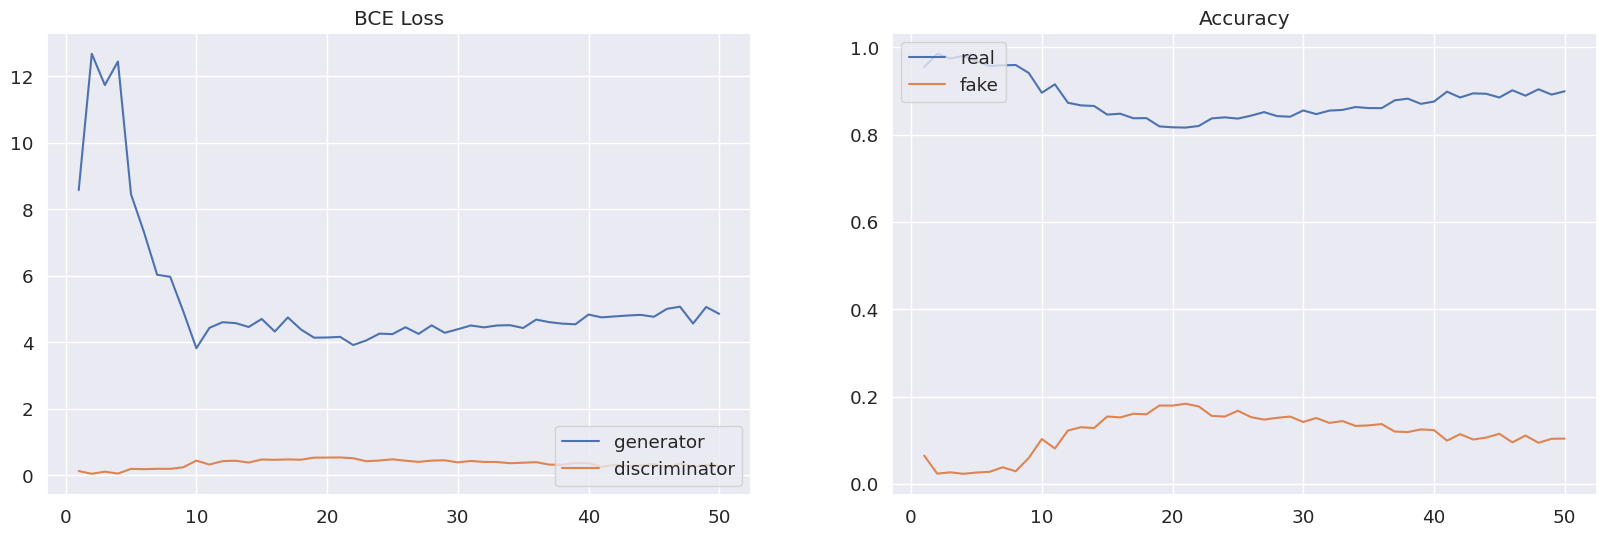

In [ ]:
    # Отрисуем графики лоссов и score
    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), loss['generator'], label='generator')
    plt.plot(range(1, epochs+1), loss['discriminator'], label='discriminator')
    plt.legend(loc='lower right')
    plt.title('BCE Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), score['real'], label='real')
    plt.plot(range(1, epochs+1), score['fake'], label='fake')
    plt.legend(loc='upper left')
    plt.title('Accuracy')

    plt.show()

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=DEVICE)
fake_images = model["generator"](fixed_latent)

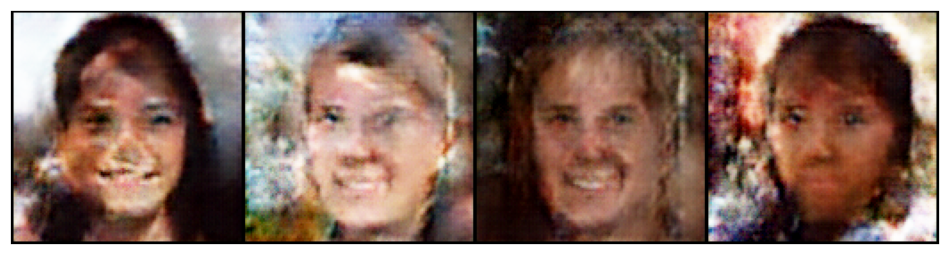

In [ ]:
imgs = fake_images.cpu()
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(
    make_grid(imgs[:4], nrow=4).permute(1, 2, 0)
)

Как вам качество получившихся изображений?

Черты читаются, но до хорошего состояния видимо надо усложнять сетку и делать больше эпох

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
num_of_imgs = 1024 # сгенерируем только 1000 изображений для экономии вычислительного времени
#num_of_imgs = 32
fixed_latent = torch.randn(num_of_imgs, latent_size, 1, 1, device=DEVICE)
fake_images = model["generator"](fixed_latent)

In [ ]:
# Формируем тензор из 1024 изображений реальных. Не из целого, чтобы сэкономить вычислительные можности на каггле
num_of_imgs = 1024
#num_of_imgs = 32 # debug

real_images = torch.Tensor()
for imgs, _ in dataloader:
    real_images = torch.cat([real_images, imgs])
    if real_images.shape[0] >= num_of_imgs:
        break

In [ ]:
print(
    len(real_images),
    len(fake_images)
)

1024 1024


In [ ]:
# Объединяем реальные и фейковые картинки
mixed_images = torch.cat((real_images.to(DEVICE), fake_images.to(DEVICE)))

In [ ]:
len(mixed_images)

2048

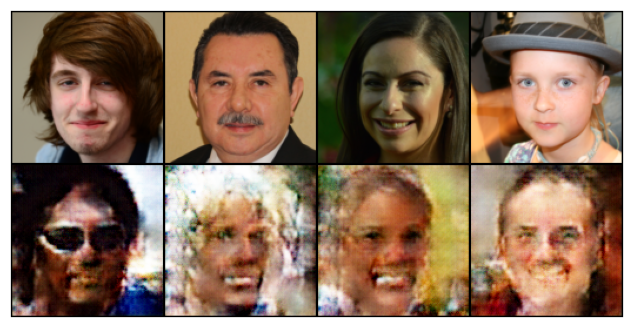

In [ ]:

imgs = mixed_images[1020:1028] #посмотрим 4 норм и 4 фейк (граница 1024)
imgs = imgs.cpu()
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(
    make_grid(imgs[:8], nrow=4).permute(1, 2, 0)
)

In [ ]:
# сформируем тензор из 1 и 0
labels = torch.cat([torch.ones(len(real_images)), torch.zeros(len(fake_images))])

In [ ]:
# распрямим тензоры картинок
mixed_images = mixed_images.flatten(start_dim=1)[:len(mixed_images), :]
mixed_images.shape

torch.Size([2048, 49152])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score

knn_model = KNeighborsClassifier(n_neighbors=1)

score = cross_val_score(knn_model, mixed_images.detach().cpu(), labels, scoring="accuracy", cv=LeaveOneOut(), error_score='raise')
print(f'Accuracy = {score.mean()}')


Accuracy = 0.83203125


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

При значительной меньшей выборке, на дебаге, результат был в районе 0.7.
Accuracy определяет насколько мы уверены в своем предсказании. Хотел бы получить ближе к 0.5, чтобы не было понятно реальное это изображение или фейк.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

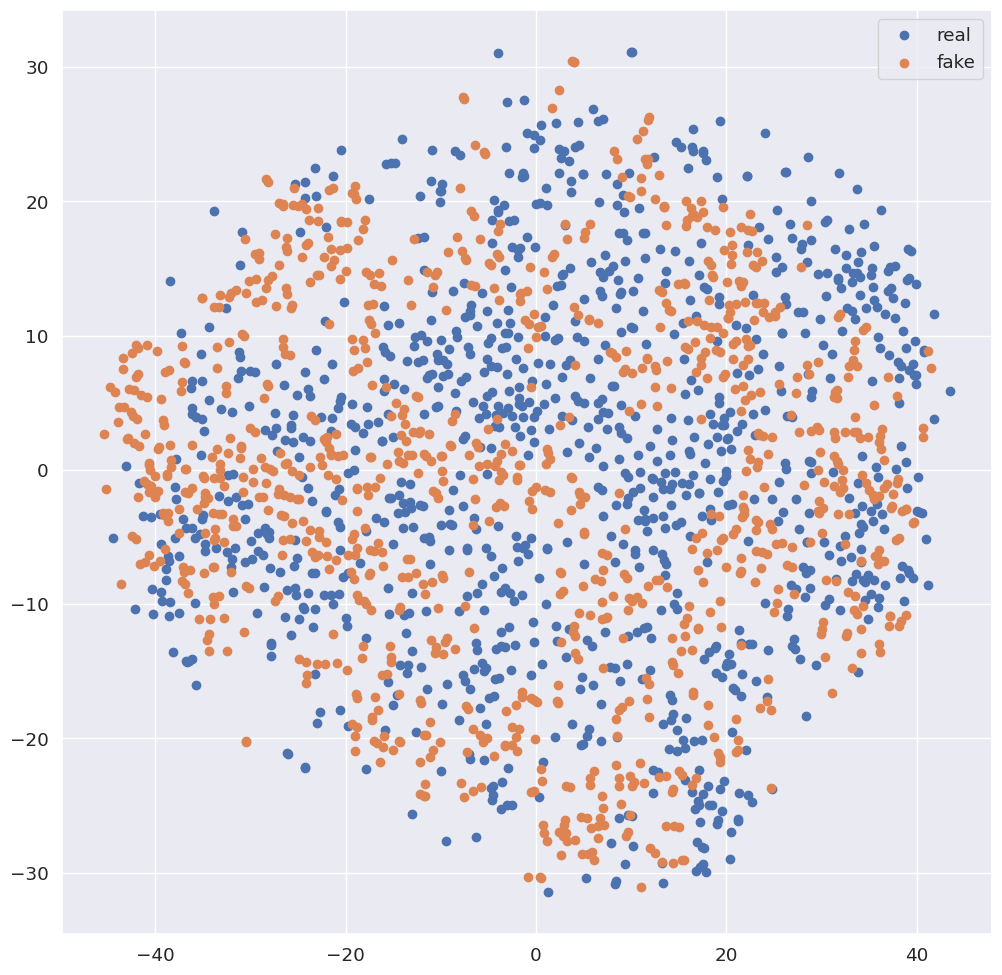

In [ ]:
from sklearn.manifold import TSNE
# t-SNE presentation

model["generator"].eval()
with torch.no_grad():
    fixed_latent = torch.randn(num_of_imgs, latent_size, 1, 1, device=DEVICE)
    fake_images = model["generator"](fixed_latent)
    fake_images = fake_images.cpu()
    real_images = real_images.cpu()

    imgs_flatten = torch.cat([
        real_images.flatten(start_dim=1)[:num_of_imgs, :],
        fake_images.flatten(start_dim=1)[:num_of_imgs, :]
    ])

    ts = TSNE(random_state=42, verbose=0).fit_transform(imgs_flatten)

fig, ax = plt.subplots(figsize=(12, 12))
#plt.title(f'Epoch {epoch}')
plt.scatter(ts[:num_of_imgs, 0], ts[:num_of_imgs, 1], label='real')
plt.scatter(ts[num_of_imgs:, 0], ts[num_of_imgs:, 1], label='fake')
plt.legend()



Прокомментируйте получившийся результат:

In [ ]:
tsne-преобразование наших картинок довольно хорошо перемешано. Идеально было бы, если бы они были перемешаны
еще равномерней, без островков одного цвета. Чем сильнее два класса перемешаны, тем сложней отличить
фейковые картинки от настоящих.